In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'clothing-dataset-full:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F929774%2F1572891%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240602%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240602T064412Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D62a908e2baa70dd55a465e89ee922c7d7e7682e90a376cf82a029e1cd2f9b27cff7bfb1ef0e04d8141abbc672843e798f78e76efac6c41f2ddfb9c6bf652ba1e0b24a6efe6a791feec5c67704ecc487bfef66dd003138e854c5387ae054bbaa750be6ef88e6e590ee88150e32430767b78ad88d7c57d51a1b3af982c11fd4932635bc8f379105d7ecbcca4635dd11baa2fa36edd86a7bc65eeb364b2a2252fd1bcffeb1f0a8c76f57f6d5005cf6f27b13a0d3e17863101a5960c10aebf0ce3d0a3aee70ccf588cdb16d6cc3d969b8b909a29b35955119f237c56d9808296d28438e1e4dd0271b05d21043b2802acf64ef2d7a8cc1980aa92898a561317d98362'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6982357507 bytes downloaded
Downloaded and uncompressed: clothing-dataset-full
Data source import complete.


# Imports

In [ ]:
import random
import os
import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub



In [ ]:
#!pip install keras_preprocessing
from keras.optimizers import Adam


In [ ]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Flatten, Dense, BatchNormalization, Activation,Dropout

from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
TRAINING_DIR = '../input/clothing-dataset-full/images_compressed'
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCHS = 100
LEARNING_RATE = 0.001

In [ ]:
print(f"There are {len(os.listdir(TRAINING_DIR))} images in training set")

There are 5762 images in training set


# Data Preprocessing

In [ ]:
file_names = os.listdir(TRAINING_DIR)
file_names[:10]

['a1609752-8a13-463b-8298-85047e8bf951.jpg',
 '0c50d57f-6132-4395-a71b-f82176293609.jpg',
 'd3db25f4-a328-487e-94e9-472bc6f02807.jpg',
 '4f475e5a-0631-4ed4-9333-2ea5931b8a52.jpg',
 '06697086-d232-4c13-a5ea-ebd759b53bc6.jpg',
 '0386a2d3-d7c2-42d4-b348-2525e6659743.jpg',
 '714fb06c-e878-47e0-aa84-e6543490980b.jpg',
 '6b1c9f42-c52e-4690-836d-d62e66d48ccb.jpg',
 'a84a847c-2006-48fd-8e4a-efe92d50466f.jpg',
 'c287c715-21bb-420c-ad4d-128d2dd3078d.jpg']

In [ ]:
data = pd.read_csv('../input/clothing-dataset-full/images.csv')

In [ ]:
data.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [ ]:
data['image'] = data['image']+'.jpg'
data_1 = data[['image', 'label']]

In [ ]:
data_1.head()

,image,label
0,4285fab0-751a-4b74-8e9b-43af05deee22.jpg,Not sure
1,ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg,T-Shirt
2,00627a3f-0477-401c-95eb-92642cbe078d.jpg,Not sure
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg,T-Shirt
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg,Shoes


In [ ]:
data_1['image']

0       4285fab0-751a-4b74-8e9b-43af05deee22.jpg
1       ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg
2       00627a3f-0477-401c-95eb-92642cbe078d.jpg
3       ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg
4       3b86d877-2b9e-4c8b-a6a2-1d87513309d0.jpg
                          ...                   
5398    dfd4079d-967b-4b3e-8574-fbac11b58103.jpg
5399    befa14be-8140-4faf-8061-1039947e329d.jpg
5400    5379356a-40ee-4890-b416-2336a7d84061.jpg
5401    65507fb8-3456-4c15-b53e-d1b03bf71a59.jpg
5402    32b99302-cec7-4dec-adfa-3d4029674209.jpg
Name: image, Length: 5403, dtype: object

Remove corrupted images from the data set

In [ ]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(TRAINING_DIR).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

../input/clothing-dataset-full/images_compressed/c60e486d-10ed-4f64-abab-5bb698c736dd.jpg
../input/clothing-dataset-full/images_compressed/1d0129a1-f29a-4a3f-b103-f651176183eb.jpg
../input/clothing-dataset-full/images_compressed/784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg
../input/clothing-dataset-full/images_compressed/040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg
../input/clothing-dataset-full/images_compressed/b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg
../input/clothing-dataset-full/images_compressed/d028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg


In [ ]:
corrupted = ['b72ed5cd-9f5f-49a7-b12e-63a078212a17.jpg', '1d0129a1-f29a-4a3f-b103-f651176183eb.jpg', 'c60e486d-10ed-4f64-abab-5bb698c736dd.jpg',
            'd028580f-9a98-4fb5-a6c9-5dc362ad3f09.jpg', '040d73b7-21b5-4cf2-84fc-e1a80231b202.jpg', '784d67d4-b95e-4abb-baf7-8024f18dc3c8.jpg']

In [ ]:
data_1 = data_1.drop(data_1[data_1['image'].isin(corrupted)].index, axis=0)

# Data Visualization

In [ ]:
fig = px.bar(data_1['label'].value_counts())
fig.show()

In [ ]:
class_names = list(data_1['label'].unique())
print(len(class_names))
class_names

20


['Not sure',
 'T-Shirt',
 'Shoes',
 'Shorts',
 'Shirt',
 'Pants',
 'Skirt',
 'Other',
 'Top',
 'Outwear',
 'Dress',
 'Body',
 'Longsleeve',
 'Undershirt',
 'Hat',
 'Polo',
 'Blouse',
 'Hoodie',
 'Skip',
 'Blazer']

In [ ]:
class_dict = dict(zip(class_names, range(len(class_names))))

In [ ]:
class_dict

{'Not sure': 0,
 'T-Shirt': 1,
 'Shoes': 2,
 'Shorts': 3,
 'Shirt': 4,
 'Pants': 5,
 'Skirt': 6,
 'Other': 7,
 'Top': 8,
 'Outwear': 9,
 'Dress': 10,
 'Body': 11,
 'Longsleeve': 12,
 'Undershirt': 13,
 'Hat': 14,
 'Polo': 15,
 'Blouse': 16,
 'Hoodie': 17,
 'Skip': 18,
 'Blazer': 19}

In [ ]:
labels_to_remove = ['Skip', 'Not sure', 'Other', 'Blouse']

In [ ]:
data_1 = data_1[~data_1['label'].isin(labels_to_remove)]

In [ ]:
fig = px.bar(data_1['label'].value_counts())
fig.show()

In [ ]:
y_train = data_1['label']

In [ ]:
def show_random_training_image():
    random_index = random.choice(data_1.index)
    img_path = data_1['image'][random_index]
    label = data_1['label'][random_index]
    complete_path = TRAINING_DIR + '/' + img_path
    image = mpimg.imread(complete_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)

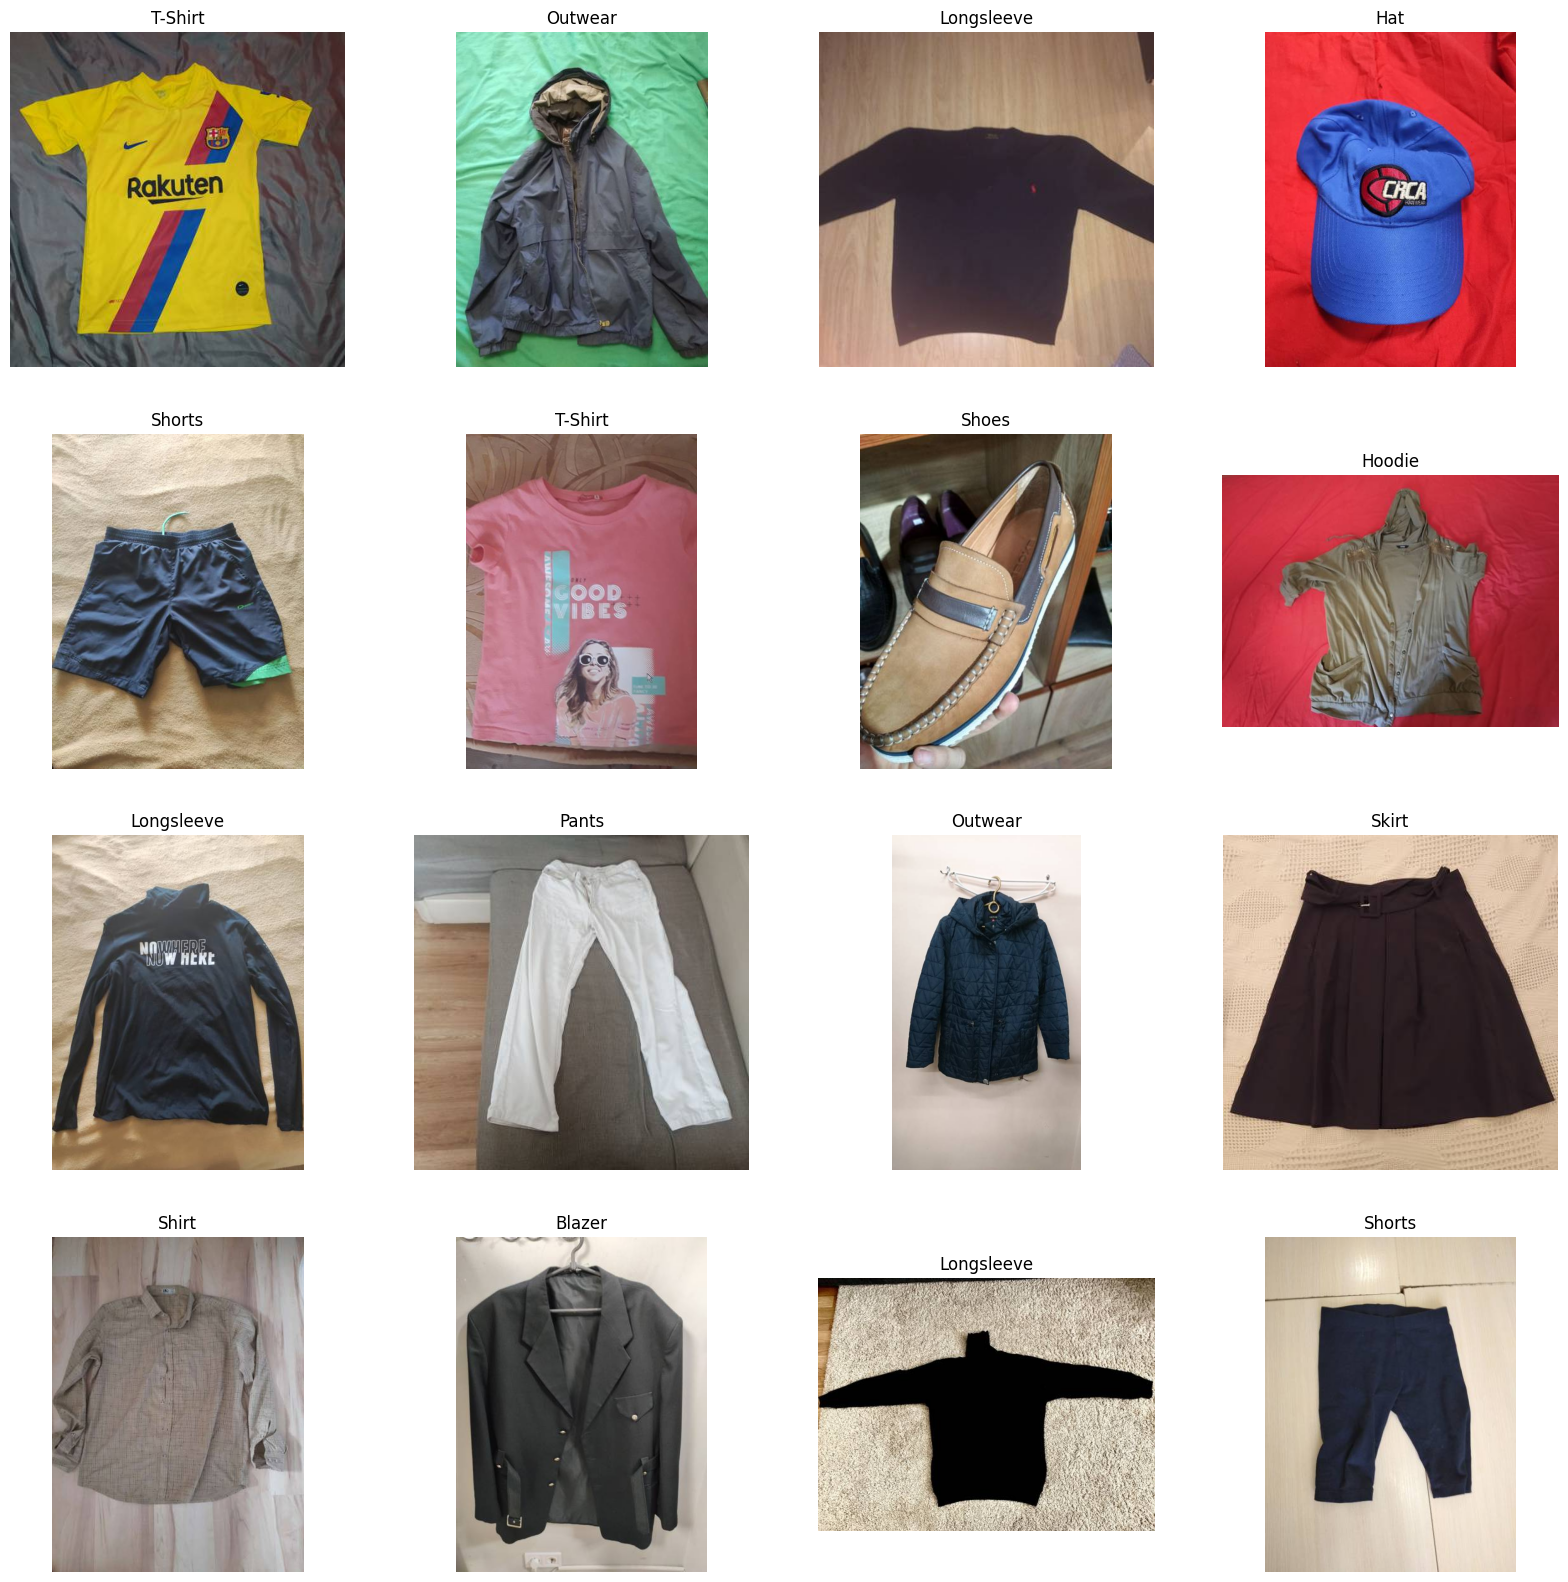

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    show_random_training_image()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.3,
                                  height_shift_range=0.3,
                                  zoom_range=0.3,
                                  horizontal_flip=True,
                                  validation_split=0.1)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_1,
    directory=TRAINING_DIR,
    x_col='image',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=data_1,
    directory=TRAINING_DIR,
    x_col='image',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation'
)

Found 4566 validated image filenames belonging to 16 classes.
Found 507 validated image filenames belonging to 16 classes.


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

pre_trained_model = MobileNetV2(input_shape=(224, 224, 3),
                                include_top=False,
                                weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = True

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('out_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

9406464/9406464 [==============================] - 0s 0us/step
last layer output shape:  (None, 7, 7, 1280)


In [ ]:
x = Flatten()(last_output)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
x = Dense(16, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

In [ ]:
pip install tensorflow


In [ ]:
#import tensorflow as tf
#print(tf.__version__)
from tensorflow.keras.optimizers import Adam as adam_v2

In [ ]:
learn_rate = LEARNING_RATE

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
cb = ModelCheckpoint('mobilenetv2.h5', save_best_only=True)
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.1, patience=5, min_lr=1e-5)

adam = adam_v2.Adam(learning_rate=learn_rate)
model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])


history = model.fit(train_generator, epochs=EPOCHS,
                    validation_data=validation_generator,
                    callbacks=[es, cb, lrr])

model = tf.keras.models.load_model('mobilenetv2.h5')

AttributeError: type object 'Adam' has no attribute 'Adam'

# Visualize Model Predictions

In [ ]:
loss, accuracy = model.evaluate(validation_generator, verbose=0)

In [ ]:
print(f"Model Loss is {loss:.2f} and Accuracy is {100*np.round(accuracy, 4)}%")

In [ ]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

In [ ]:
plot_loss_curves(history)

# Prediction on validation Images

In [ ]:
classes = list(train_generator.class_indices.keys())

In [ ]:
def predict_val_image(index):
    predictions =  model.predict(val_images, verbose=0)[index]
    true_label = classes[val_labels[index].argmax()]
    predicted_label = classes[predictions.argmax()]

    if(true_label== predicted_label):
        color = 'green'
    else:
        color = 'red'

    plt.title(f"True : {true_label} Predicted: {predicted_label}", color=color)
    plt.imshow(val_images[index])
    plt.axis('off')

In [ ]:
val_images, val_labels = validation_generator.next()
plt.figure(figsize=(20, 20))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    predict_val_image(i)

# Predictions on Unseen Images

In [ ]:
custom_dir = '../input/clothing-dataset-full/images_original'

In [ ]:
custom_paths = []
for image in os.listdir(custom_dir):
        custom_paths.append(custom_dir+'/'+image)

In [ ]:
def predict_random_image():
    path = random.choice(custom_paths)
    image = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    input_arr = input_arr.astype('float32') / 255.
    predictions = model.predict(input_arr, verbose=0)
    series = pd.Series(predictions[0], index=classes)
    predicted_classes = np.argsort(predictions)
    predictions.sort()
    plt.title(f"{classes[predicted_classes[0][-1]]} - {round(predictions[0][-1] * 100,2)}% \n{classes[predicted_classes[0][-2]]} - {round(predictions[0][-2] * 100,2)}% \n{classes[predicted_classes[0][-3]]} - {round(predictions[0][-2] * 100,3)}%")
    plt.imshow(image)
    plt.axis('off')

## Top 3 predictions for unseen High-res Images

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    predict_random_image()